In [208]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import scipy.stats as scs
import sklearn as sk
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import VotingClassifier
from sklearn import decomposition
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from statsmodels.stats.diagnostic import het_white , normal_ad
from sklearn.linear_model import LinearRegression
from statsmodels.api import Logit
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from statsmodels.stats.diagnostic import  normal_ad
from sklearn.cluster import KMeans
from pandas import Series,DataFrame
import warnings
warnings.filterwarnings("ignore")

## Ouverture des fichiers

In [209]:
df = pd.read_csv("OneDrive/Bureau/Data Analyst Open Classroom/P10/billets.csv", delimiter=';')

In [210]:
df

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,4.42,3.09,111.28
1496,False,172.19,104.63,104.44,5.27,3.37,110.97
1497,False,171.80,104.01,104.12,5.51,3.36,111.95
1498,False,172.06,104.28,104.06,5.17,3.46,112.25


In [211]:
test = pd.read_csv("OneDrive/Bureau/Data Analyst Open Classroom/P10/billets_production.csv")

In [212]:
test

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


## Analyse des fichiers

In [213]:
df.duplicated().sum()

0

In [214]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [215]:
df.isna().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

In [216]:
# Separation des donnees des donnees manquantes:
Reg_Lin_Train_df = df.dropna()
Reg_Lin_Test_df = df[df.isnull().any(axis=1)]

# Creation de X_train et Y_train:
x_train = Reg_Lin_Train_df.drop("margin_low", axis=1)
y_train = Reg_Lin_Train_df["margin_low"]

# Regression lineaire:
reg_lin = LinearRegression()
model_reg_lin = reg_lin.fit(x_train, y_train)

# Predictions:
x_train = Reg_Lin_Train_df[["is_genuine","diagonal","height_left","height_right", "margin_up", "length"]]
Reg_Lin_Train_df["margin_low_pred"] = reg_lin.predict(x_train)

In [217]:
print("Intercept:", model_reg_lin.intercept_)
print("Coéfficients:", model_reg_lin.coef_)

Intercept: 2.866822892054368
Coéfficients: [-1.14059676 -0.0130159   0.02829069  0.02674982 -0.21284432 -0.00388299]


In [218]:
# Instanciation:
reg_linb = smf.ols("margin_low ~ diagonal + height_left + height_right + margin_up + length + is_genuine", data = df)

# Calculs:
res_lin = reg_linb.fit()
print(res_lin.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     390.7
Date:                Sun, 16 Apr 2023   Prob (F-statistic):          4.75e-299
Time:                        00:54:28   Log-Likelihood:                -774.14
No. Observations:                1463   AIC:                             1562.
Df Residuals:                    1456   BIC:                             1599.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              2.8668      8

# Régression linéaire

### Pour combler les valeurs manquantes du dataframe, nous allons procéder à une régression linéaire pour les combler (par imputation), comme laissé dans le post-it par un de nos collègues

### Mais avant cela, nous allons vérifier certaines conditions pour prouver que la régression linéaire peut être la méthode approprié pour prédire les valeurs manquantes :

<ol>
  <li>Les données doivent être linéaires</li>
  <li>Normalité des résidus : résidus de la régression doivent suivre une distribution normale</li>
  <li>Homoscédasticité : Les résidus de la régression doivent avoir une variance constante</li>
  <li>Aucune colinéarité : il ne doit y avoir aucune corrélation élevée entre les variables explicatives</li>
  
</ol>

## 1. Données linéaires

#### Test de Kolmogorov-Smirnov

In [219]:
liste_var = ["height_left","height_right","margin_low","margin_up","length","diagonal"]


In [220]:
liste_var = liste_var
for var in liste_var :
    print(var,":",scs.ks_2samp(df[var],list(np.random.normal(np.mean(df[var]), np.std(df[var]), 1000))))

height_left : KstestResult(statistic=0.029333333333333333, pvalue=0.6723949429198268)
height_right : KstestResult(statistic=0.029666666666666668, pvalue=0.6586292316713649)
margin_low : KstestResult(statistic=0.096, pvalue=2.9715078216262137e-05)
margin_up : KstestResult(statistic=0.04466666666666667, pvalue=0.1786204470840735)
length : KstestResult(statistic=0.139, pvalue=1.4944582999772155e-10)
diagonal : KstestResult(statistic=0.031, pvalue=0.6036491108686072)


In [221]:
df

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,4.42,3.09,111.28
1496,False,172.19,104.63,104.44,5.27,3.37,110.97
1497,False,171.80,104.01,104.12,5.51,3.36,111.95
1498,False,172.06,104.28,104.06,5.17,3.46,112.25


## 2. Normalité des résidus

p-value du test d'Anderson-Darling : 3.9857722331535204e-05


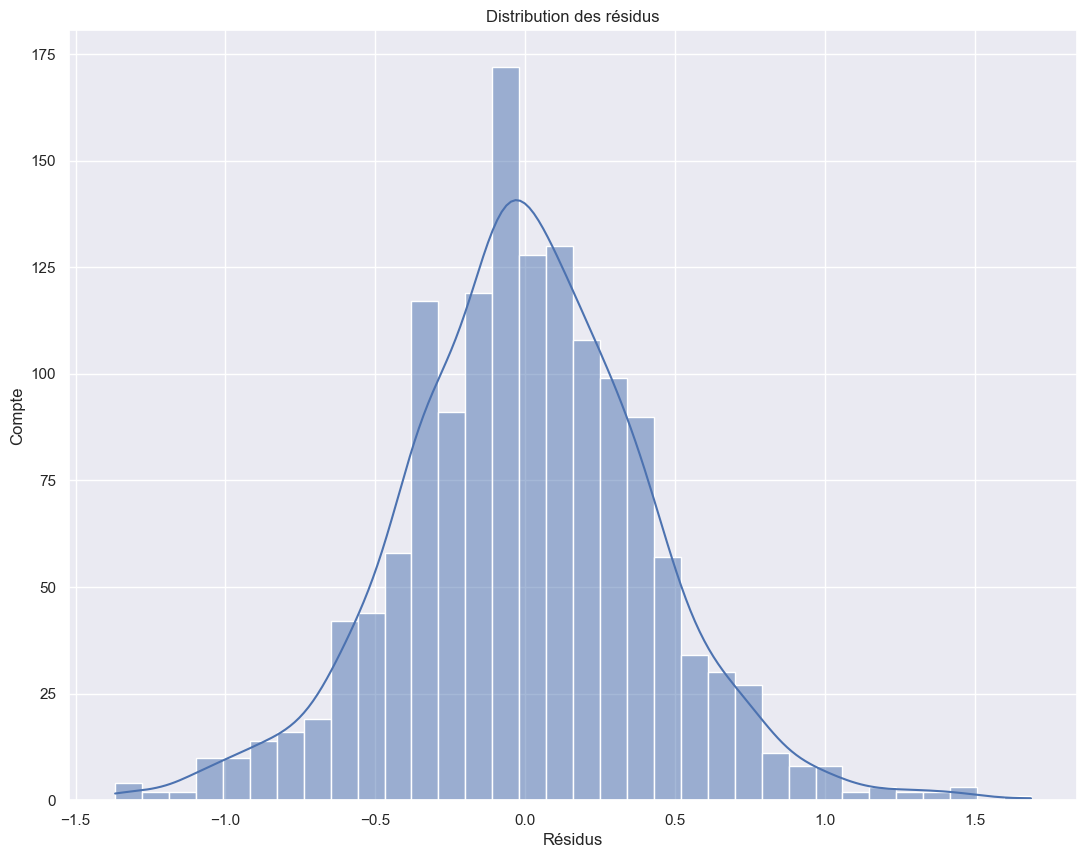

In [222]:
# Creation d'une colonne contenant les residus:
Reg_Lin_Train_df["residual"] = Reg_Lin_Train_df["margin_low"] - Reg_Lin_Train_df["margin_low_pred"]

# Normalite:
print("p-value du test d'Anderson-Darling :", normal_ad(Reg_Lin_Train_df["residual"])[1])

sns.histplot(Reg_Lin_Train_df["residual"], kde=True)
plt.xlabel("Résidus")
plt.ylabel("Compte")
plt.title("Distribution des résidus")
plt.show()

### p-value < 5%

## 3. Homoscédasticité

In [223]:
# Homoscedasticite:
white_test = het_white(res_lin.resid, res_lin.model.exog)
labels_white_test = ["Test Statistic", "p-value", "F-Statistic", "F-Test p-value"]
print(dict(zip(labels_white_test, white_test)))

{'Test Statistic': 185.4402476042699, 'p-value': 5.21588195846593e-26, 'F-Statistic': 8.016852051203028, 'F-Test p-value': 4.616518789123627e-28}


Text(0.5, 1.0, 'Homoscédasticité')

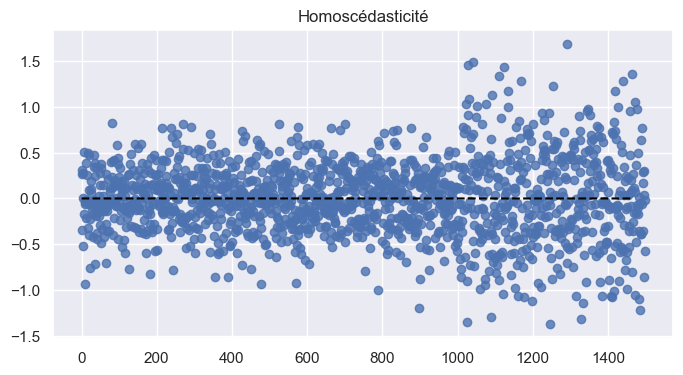

In [224]:
# Graphique:
plt.subplots(figsize=(8, 4))
plt.scatter(x=Reg_Lin_Train_df.index, y=Reg_Lin_Train_df["residual"], alpha=0.8)
plt.plot(np.repeat(0, len(Reg_Lin_Train_df.index)+2), color="black", linestyle='--')
plt.title("Homoscédasticité")

### p value extrêmement inférieur à alpha (5%) il n'y a donc pas homoscédasticité

## 4. Colinéarité

In [225]:
# Multicollinearite:
vif= pd.Series([variance_inflation_factor(Reg_Lin_Train_df[["diagonal","height_left","height_right", "margin_up", "length"]].values, i)
               for i in range(Reg_Lin_Train_df[["diagonal","height_left","height_right", "margin_up", "length"]].shape[1])],
              index=Reg_Lin_Train_df[["diagonal","height_left","height_right", "margin_up", "length"]].columns)
print("VIF pour :\n",vif.round(2))
print("moyenne vif :",vif.mean())

VIF pour :
 diagonal        170566.67
height_left     111895.31
height_right    100858.86
margin_up          261.97
length           22708.22
dtype: float64
moyenne vif : 81258.20741161003


#### Une VIF élevée indique une forte corrélation, ce qui suggère une multicolinéarité

### Les hypothèses de validité ne sont pas validées, nous allons tout de même procéder à l'application du modèle, cependant il faudra garder à l'esprit que les hypothèses non validées peuvent mener une inexactitude des valeurs prédites

## Ajout des valeurs prédites aux valeurs manquantes

In [226]:
# Application du modele sur les donnees test
x_test = Reg_Lin_Test_df[["is_genuine","diagonal","height_left","height_right", "margin_up","length"]]
Reg_Lin_Test_df["margin_low"] = reg_lin.predict(x_test)

# Concatenation:
reg_lin_result = [Reg_Lin_Test_df, Reg_Lin_Train_df]
df = pd.concat(reg_lin_result)
df = df.drop(["margin_low_pred", "residual"], axis=1)

df.describe().round(3)

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000,1500.000,1500.000,1500.000,1500.000,1500.000
mean,171.958,104.030,103.920,4.483,3.151,112.679
std,0.305,0.299,0.326,0.660,0.232,0.873
min,171.040,103.140,102.820,2.980,2.270,109.490
25%,171.750,103.820,103.710,4.028,2.990,112.030
50%,171.960,104.040,103.920,4.310,3.140,112.960
75%,172.170,104.230,104.150,4.870,3.310,113.340
max,173.010,104.880,104.950,6.900,3.910,114.440


### Il n'y a plus de valeur manquante, et le reste est très peu voire inchangé

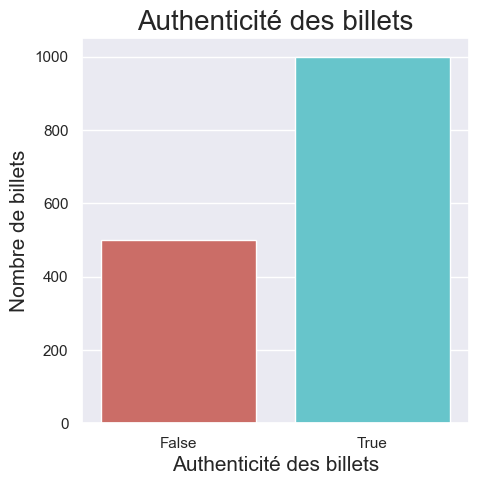

In [227]:
plt.figure(figsize=(5,5))
sns.countplot(x='is_genuine', data=df, palette='hls')
plt.xlabel('Authenticité des billets',fontsize=15)
plt.ylabel("Nombre de billets",fontsize=15)
plt.title("Authenticité des billets",fontsize=20)

plt.show()

In [228]:
df.is_genuine.value_counts()

True     1000
False     500
Name: is_genuine, dtype: int64

### 2/3 des billets sont des vrais, et 1/3 de billets sont des faux

## Correlation entre les données

Populating the interactive namespace from numpy and matplotlib


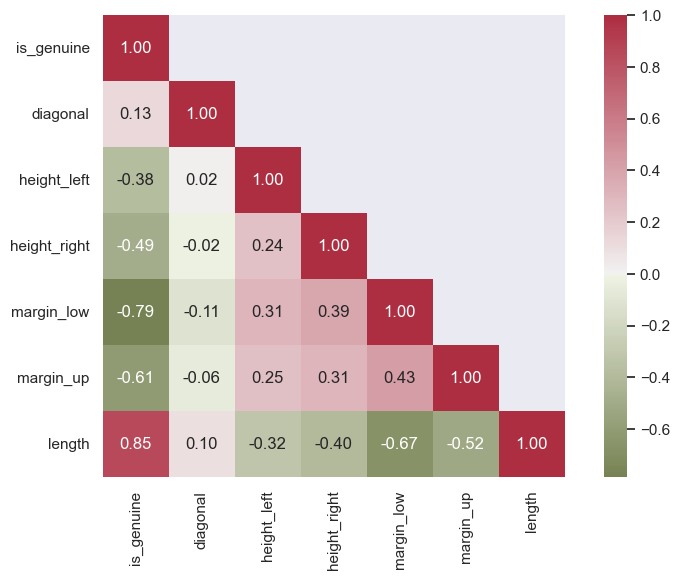

In [229]:
%pylab inline
corr =  df.corr()

# Create a mask
mask = np.triu(np.ones_like(corr, dtype=bool))
np.fill_diagonal(mask, False)

cmap = sns.diverging_palette(100, 7, s=75, l=40,
                            n=5, center="light", as_cmap=True)

plt.figure(figsize=(10, 6))
sns.heatmap(corr, mask=mask, center=0, annot=True,
            fmt='.2f', square=True, cmap=cmap)
plt.show()


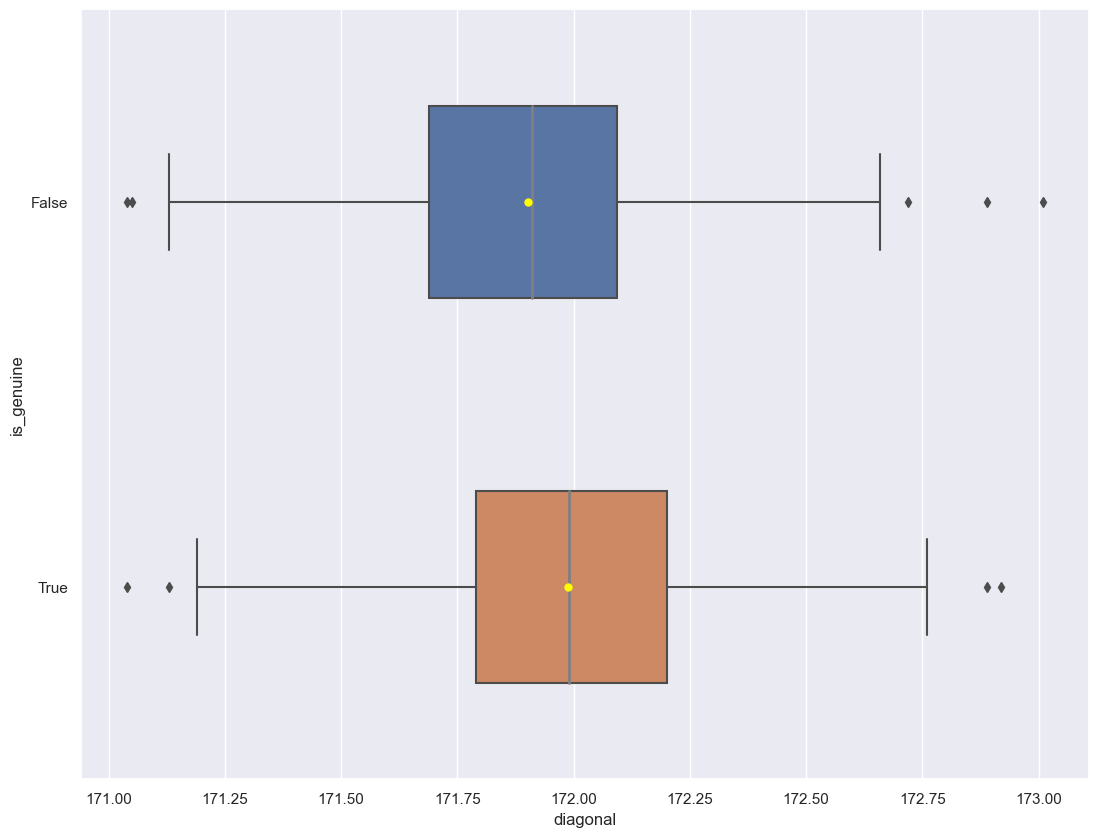

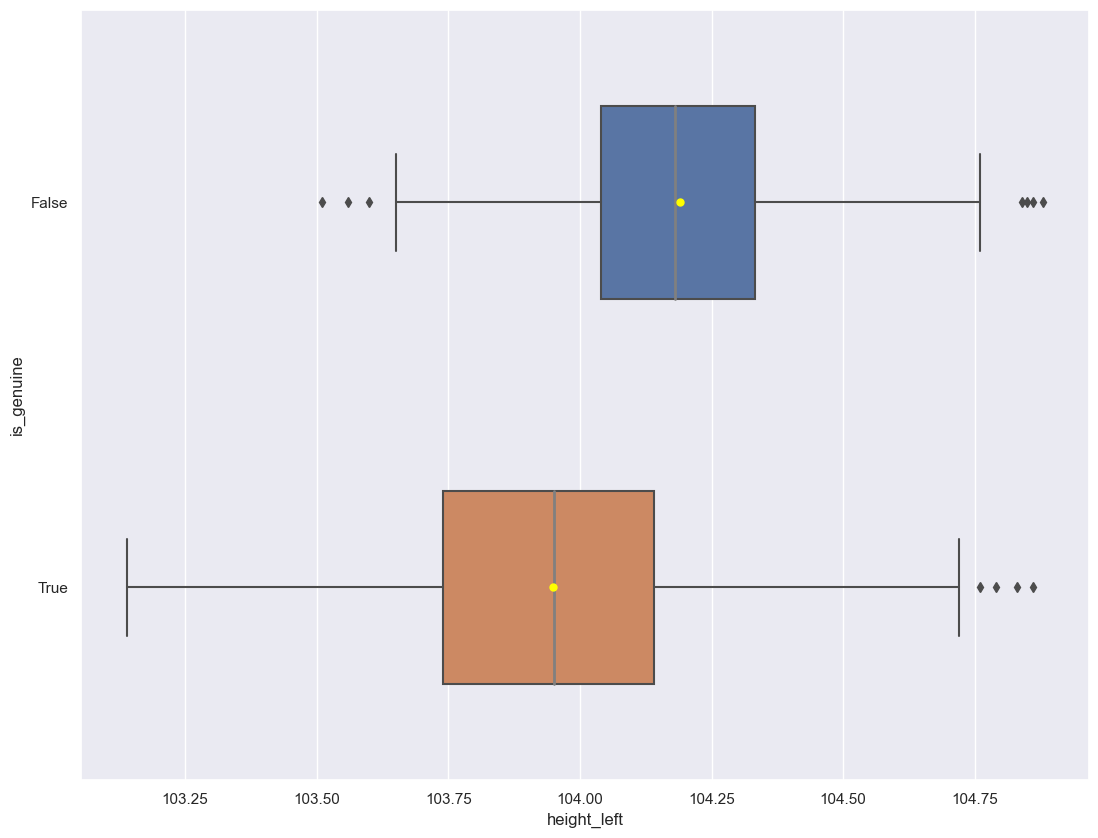

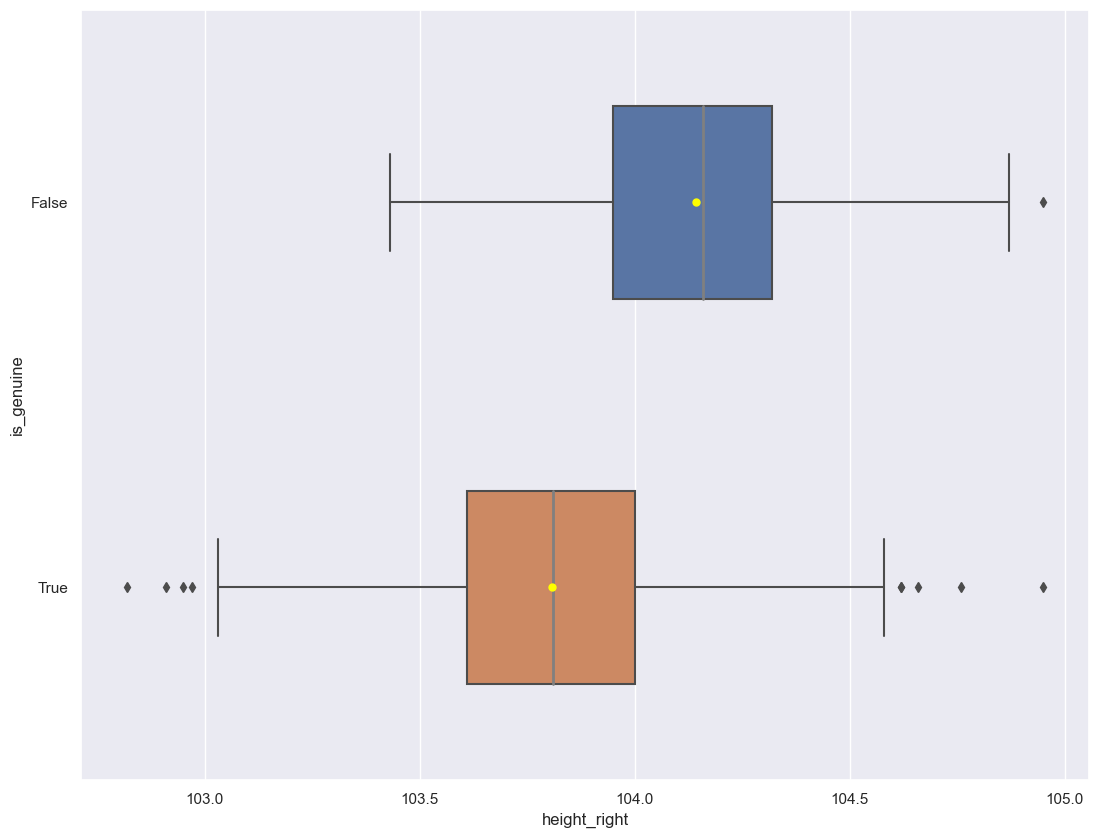

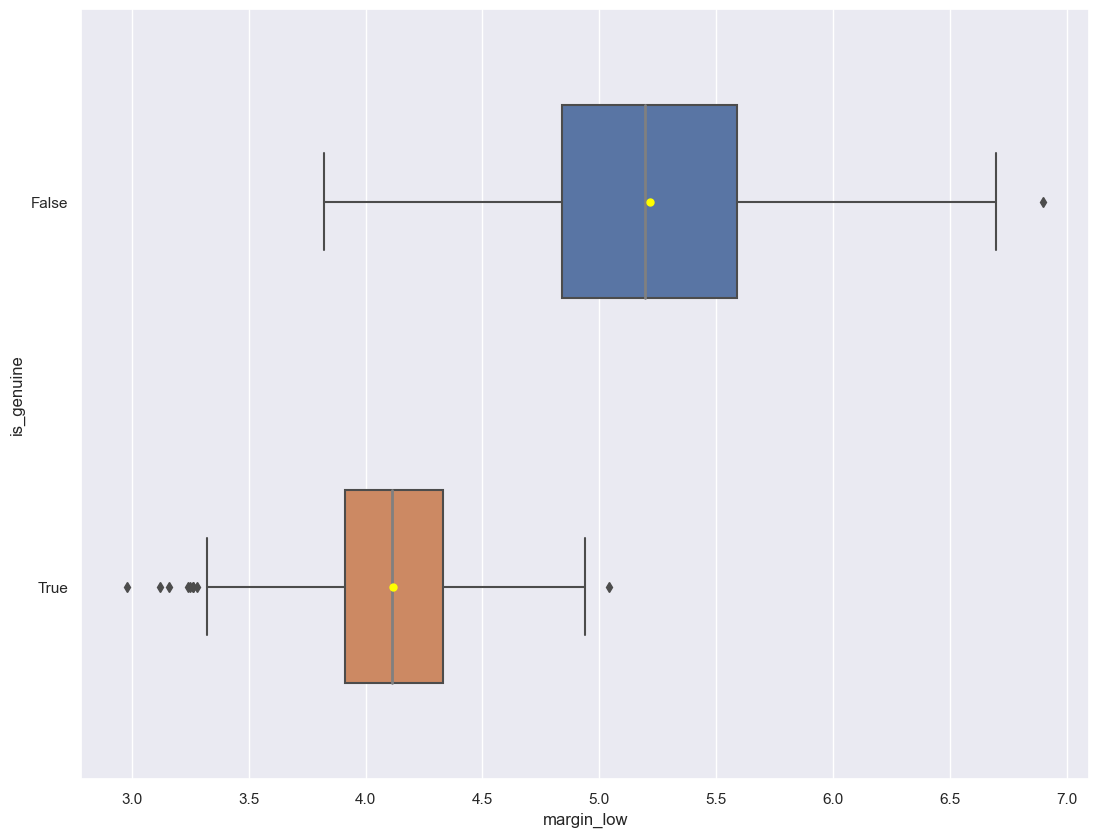

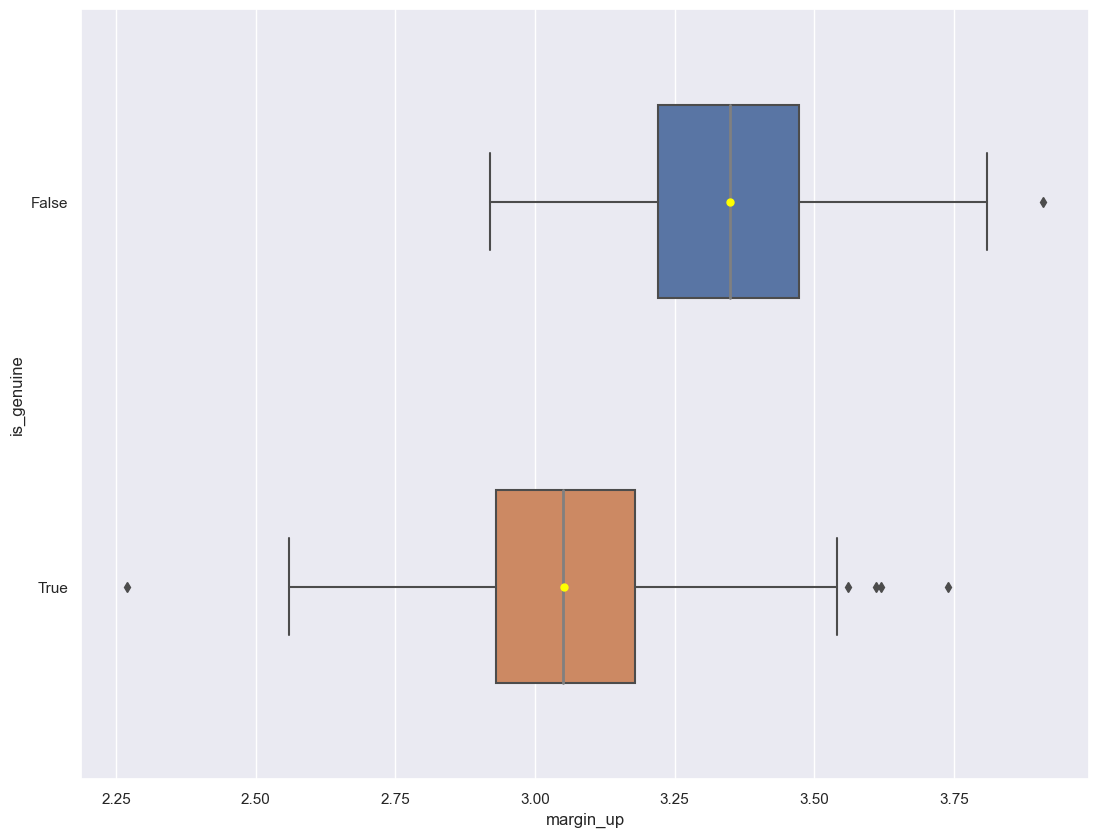

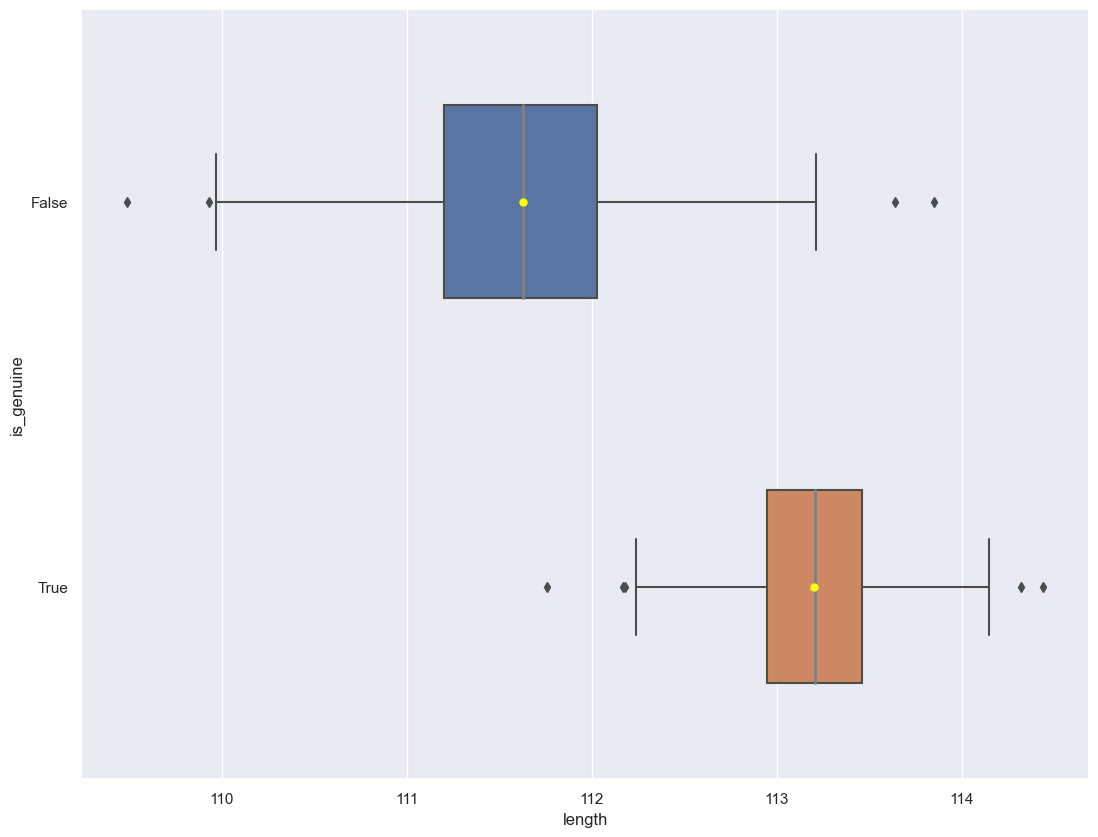

In [230]:
# Comparaison entre les dimensions des vrais et faux billets (boxplot)
medianprops = dict(linewidth=2, color='grey')
meanprops={"marker":"o","markerfacecolor":"yellow", "markeredgecolor":"yellow","markersize":"5"}

for variable in df.columns[1:7]:
    sns_plot=sns.boxplot(
        x = df[variable], 
        y = df.is_genuine,
        orient = "h",
        medianprops = medianprops, showmeans=True, meanprops=meanprops,width = .5)
    plt.show()

In [231]:
matrix = df.corr()
matrix

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
is_genuine,1.000000,0.132756,-0.379833,-0.485092,-0.786177,-0.606262,0.849285
diagonal,0.132756,1.000000,0.019472,-0.024492,-0.110639,-0.055649,0.097587
height_left,-0.379833,0.019472,1.000000,0.242279,0.308724,0.246522,-0.320863
height_right,-0.485092,-0.024492,0.242279,1.000000,0.390948,0.307005,-0.401751
margin_low,-0.786177,-0.110639,0.308724,0.390948,1.000000,0.429600,-0.668445
margin_up,-0.606262,-0.055649,0.246522,0.307005,0.429600,1.000000,-0.520575
length,0.849285,0.097587,-0.320863,-0.401751,-0.668445,-0.520575,1.000000


## ACP

#### Analyse multivariée qui peu sensible à la multicolinéarité

In [232]:
# préparation des données 
# choix du nombre de composantes à calculer
n_comp = 7
selected_variables = ["is_genuine","diagonal","height_left","height_right","margin_low","margin_up","length"]
df = df[selected_variables]
X = df
nom_variable = X.columns

In [233]:
# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

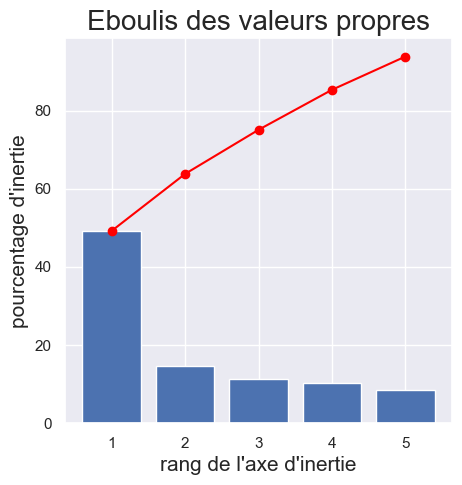

In [234]:
# choix du nombre de composantes à calculer
n_comp = 5

# Calcul des composantes principales
pca = sk.decomposition.PCA(n_components=n_comp)

pca.fit(X_scaled)


plt.figure(figsize=(5,5))
plt.xlabel("rang de l'axe d'inertie", fontsize=15)
plt.ylabel("pourcentage d'inertie", fontsize=15)
plt.title("Eboulis des valeurs propres",fontsize=20)

scree = pca.explained_variance_ratio_*100
plt.bar(np.arange(len(scree))+1, scree)
plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')

plt.show()


In [235]:
#Nombre d'observations 
n = df.shape[0]

#Nombre de variables
p = df.shape[1]

#instanciation
pca = decomposition.PCA(svd_solver='full')

#calcul
coord = pca.fit_transform(X_scaled)

#valeur corrigée
eigval = (n-1)/n*pca.explained_variance_ 

#racine carrée des valeurs propres
sqrt_eigval = np.sqrt(eigval)

#corrélation des variables avec les axes
corvar = np.zeros((p,p))
for k in range(p):
    corvar[:,k] = pca.components_[k,:] * sqrt_eigval[k]

#cosinus carré des variables
cos2var = corvar**2

#contributions
ctrvar = cos2var
for k in range(p):
    ctrvar[:,k] = ctrvar[:,k]/eigval[k]
    
#affichage
pd.DataFrame({'variable':df.columns,'F1':ctrvar[:,0],'F2':ctrvar[:,1]})

,variable,F1,F2
0,is_genuine,0.259078,0.002025
1,diagonal,0.005807,0.863166
2,height_left,0.070858,0.111880
3,height_right,0.104703,0.017931
4,margin_low,0.199341,0.003524
5,margin_up,0.139730,0.000166
6,length,0.220483,0.001308


In [236]:
variance = pd.DataFrame(
    {
        "Dimension" : ["Dim" + str(x + 1) for x in range(7)], 
        "Variance expliquée" : pca.explained_variance_,
        "% Variance expliquée" : np.round(pca.explained_variance_ratio_ * 100),
        "% Variance cumulée expliquée" : np.round(np.cumsum(pca.explained_variance_ratio_) * 100)
    }
)
variance

,Dimension,Variance expliquée,% Variance expliquée,% Variance cumulée expliquée
0,Dim1,3.447520,49.0,49.0
1,Dim2,1.020686,15.0,64.0
2,Dim3,0.789753,11.0,75.0
3,Dim4,0.716492,10.0,85.0
4,Dim5,0.595760,9.0,94.0
5,Dim6,0.324340,5.0,98.0
6,Dim7,0.110119,2.0,100.0


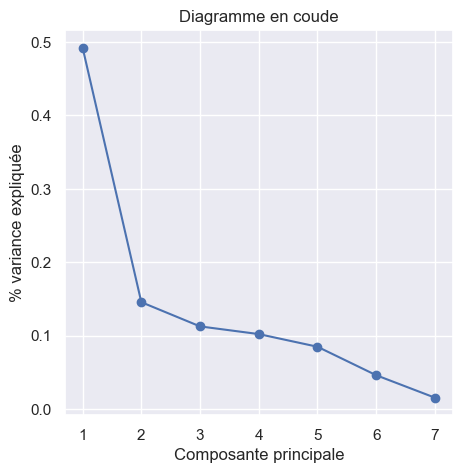

In [237]:
data = (df - df.mean()) / df.std()
pca = PCA()
pca.fit(data)
variance_ratios = pca.explained_variance_ratio_

# Affichage du diagramme
plt.figure(figsize=(5,5))
plt.plot(range(1, len(variance_ratios) + 1), variance_ratios, marker='o')
plt.xlabel('Composante principale')
plt.ylabel('% variance expliquée')
plt.title('Diagramme en coude')
plt.show()

In [238]:
# Fonction qui me permet d'afficher mes cercles de corrélations
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(8,8))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="orange")
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
pcs = pca.components_

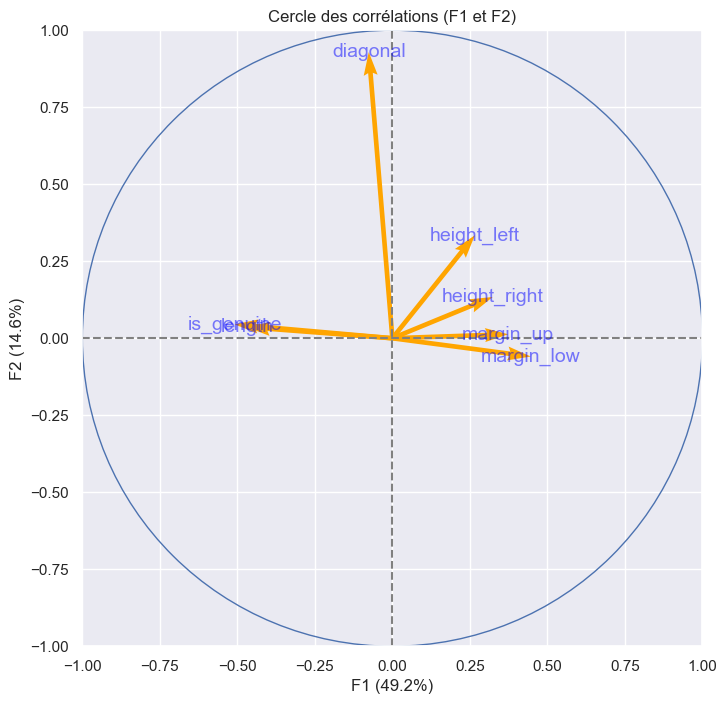

In [239]:
# Générer le Cercle des corrélations F1 et F2.
pcs = pca.components_ 
display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(X.columns))

In [240]:
# Clustering hiérarchique
Z = linkage(X_scaled,method='ward',metric='euclidean')

In [241]:
# Création d'une colonne "cluster"
clusters = fcluster(Z, 2, criterion='maxclust')

# Création d'un df avec une colonne cluster et une colonne zone
groupes = pd.DataFrame({"cluster": clusters, "est authentique": df["is_genuine"]})

print(groupes)

      cluster  est authentique
72          2             True
99          2             True
151         2             True
197         2             True
241         2             True
...       ...              ...
1495        1            False
1496        1            False
1497        1            False
1498        1            False
1499        1            False

[1500 rows x 2 columns]


In [242]:
# Définition de la fonction pour le graphique Projection des individus sur les plans factoriels
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1, d2 in axis_ranks:
        if d2 < n_comp:

            # initialisation de la figure
            fig = plt.figure(figsize=(10, 10))

            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1],
                            X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(
                        X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i, (x, y) in enumerate(X_projected[:, [d1, d2]]):
                    plt.text(x, y, labels[i],
                             fontsize='14', ha='center', va='center')

            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1, d2]])) * 1.1
            plt.xlim([-boundary, boundary])
            plt.ylim([-boundary, boundary])

            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(
                d1+1, round(100*pca.explained_variance_ratio_[d1], 1)))
            plt.ylabel('F{} ({}%)'.format(
                d2+1, round(100*pca.explained_variance_ratio_[d2], 1)))

            plt.title(
                "Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

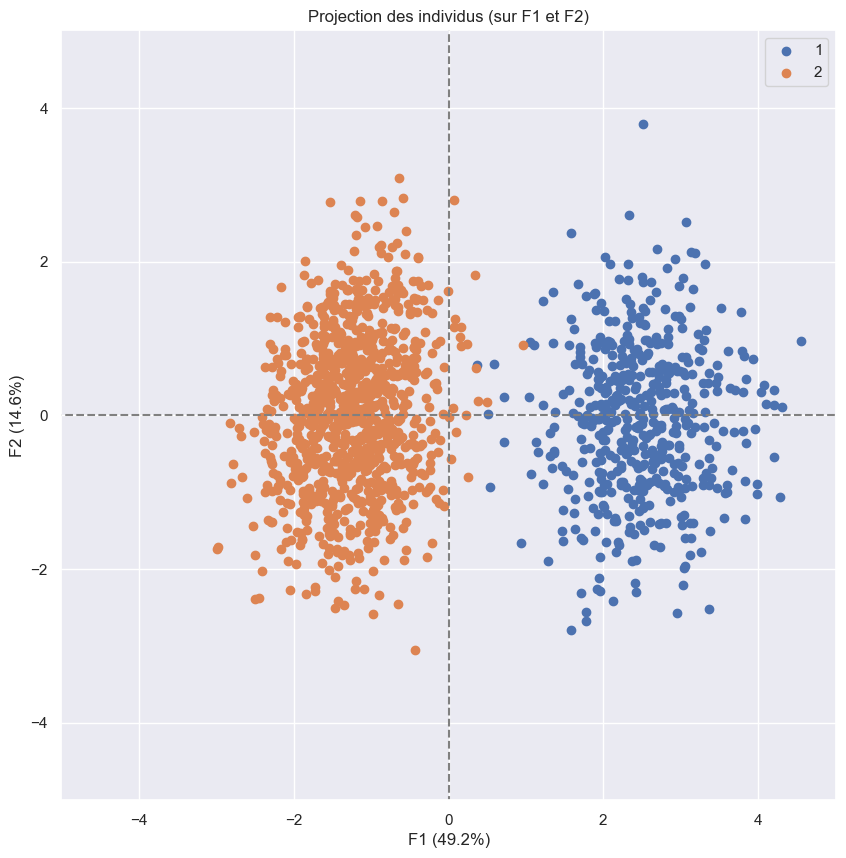

In [243]:
# Projection des individus sur F1 et F2
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1)],
                         labels=None, illustrative_var=clusters)
plt.show()

### L'axe F1 sépare les vrais billets des faux 

In [244]:
# Mise à l'échelle des données
df_scaled = pd.DataFrame(X_scaled, columns= list(nom_variable), index=df.index)

In [245]:
df_scaled

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,0.707107,-0.060441,-0.466103,-1.444792,-0.633476,0.425168,0.127803
99,0.707107,-0.093217,0.135176,0.797784,-0.562173,-0.049510,0.460204
151,0.707107,0.365659,-0.766742,1.412188,-0.528804,-0.567341,0.288272
197,0.707107,-1.666506,-1.234404,-0.369585,-0.741684,2.021814,0.677984
241,0.707107,-0.420986,0.369007,0.429141,-0.519108,-0.567341,-0.365069
...,...,...,...,...,...,...,...
1495,-1.414214,-0.683201,1.170713,0.767063,-0.095265,-0.265273,-1.602978
1496,-1.414214,0.758981,2.005822,1.596509,1.193240,0.942999,-1.958303
1497,-1.414214,-0.519316,-0.065250,0.613462,1.557053,0.899846,-0.835016
1498,-1.414214,0.332882,0.836669,0.429141,1.041651,1.331372,-0.491152


In [246]:
df_final_clusters = pd.merge(df_scaled, groupes, on=df.index)

In [247]:
# Calcul de la moyenne des variables pour chaque cluster 
df_final_clusters_moy = df_final_clusters.groupby('cluster').agg(['mean'])

In [248]:
df_final_clusters_moy
df_final_clusters_moy = df_final_clusters_moy.drop(df_final_clusters_moy.columns[[0,1]],axis = 1)

<Figure size 1300x1000 with 0 Axes>

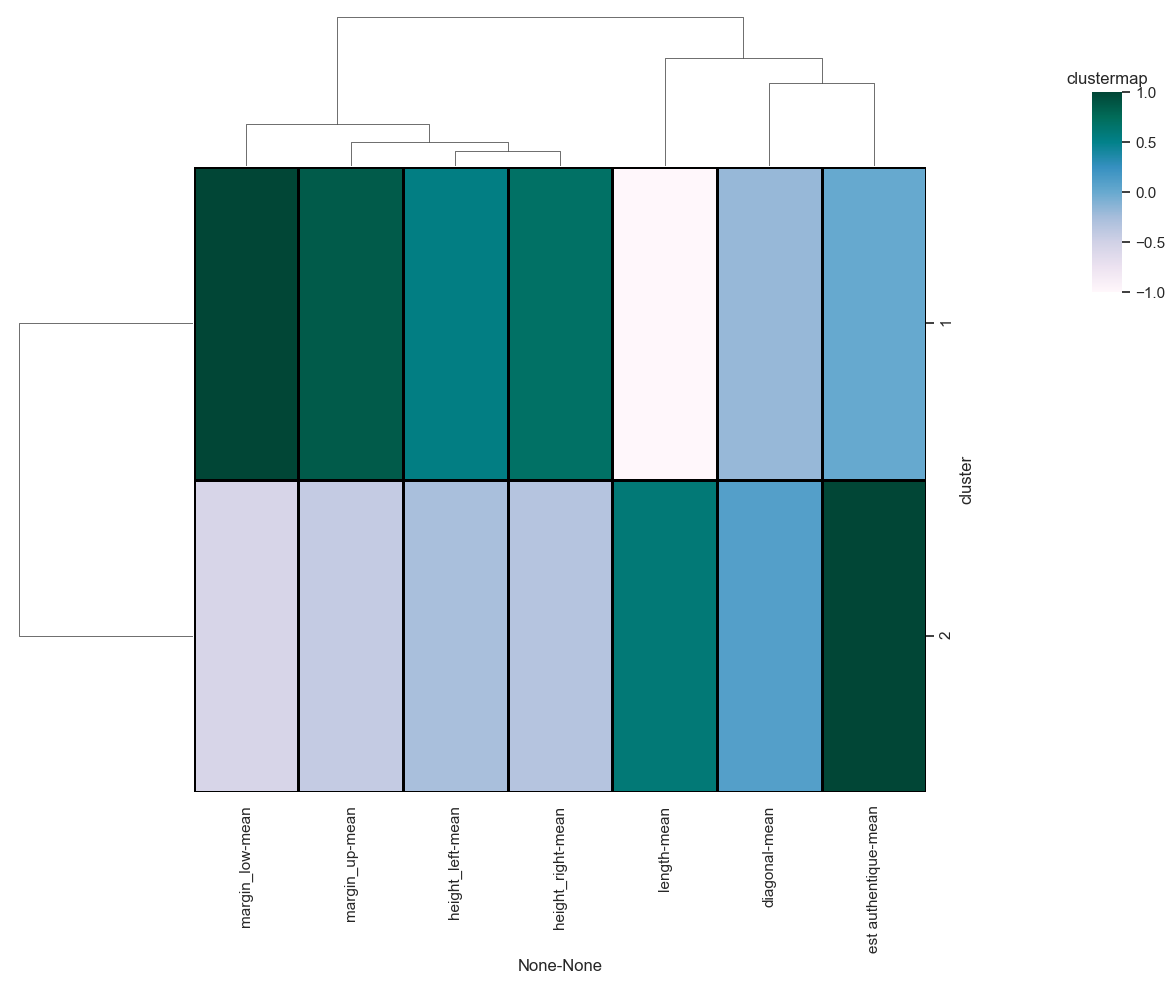

In [249]:
# Création d'une clustermap
plt.figure()
sns.set(rc={'figure.figsize':(13,10)})
sns.clustermap(df_final_clusters_moy,cmap ="PuBuGn", linecolor='black',linewidths=1,vmin=-1, vmax=1,cbar_pos=(1.1, 0.7, .03, .2))
plt.title('clustermap')
plt.show()

# <font color='red'>Regression logistique</font>  

In [250]:
y_billet = df.loc[:, df.columns == "is_genuine"]

In [251]:
print(y_billet.value_counts())                                  

is_genuine
True          1000
False          500
dtype: int64


In [252]:
X_billet = df.loc[:, df.columns != "is_genuine"]
X_billet = sm.tools.add_constant(X_billet)                     

In [253]:
print(X_billet.head())

     const  diagonal  height_left  height_right  margin_low  margin_up  length
72     1.0    171.94       103.89        103.45    4.064954       3.25  112.79
99     1.0    171.93       104.07        104.18    4.111990       3.14  113.08
151    1.0    172.07       103.80        104.38    4.134003       3.02  112.93
197    1.0    171.45       103.66        103.80    3.993571       3.62  113.27
241    1.0    171.83       104.14        104.06    4.140399       3.02  112.36


In [254]:
# Regression logistique:
reg_log = Logit(endog=y_billet,exog=X_billet)

# Calculs:
res_log = reg_log.fit()

# Resume des resultats:
print(res_log.summary())

Optimization terminated successfully.
         Current function value: 0.026349
         Iterations 13
                           Logit Regression Results                           
Dep. Variable:             is_genuine   No. Observations:                 1500
Model:                          Logit   Df Residuals:                     1493
Method:                           MLE   Df Model:                            6
Date:                Sun, 16 Apr 2023   Pseudo R-squ.:                  0.9586
Time:                        00:54:31   Log-Likelihood:                -39.524
converged:                       True   LL-Null:                       -954.77
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -230.4143    249.954     -0.922      0.357    -720.316     259.487
diagonal         0.256

In [255]:
# On ne garde que les variables significatives a alpha = 5% dans X_Billet:
X_billet = df[["height_right", "margin_low", "margin_up", "length"]]
X_billet = sm.add_constant(X_billet)

# On recommence la regression logistique:
reg_log = Logit(endog=y_billet,exog=X_billet)

# Creation du modele:
model_reg_log = reg_log.fit()

# Resume des resultats:
print(model_reg_log.summary2())

Optimization terminated successfully.
         Current function value: 0.026815
         Iterations 13
                         Results: Logit
Model:                Logit            Pseudo R-squared: 0.958   
Dependent Variable:   is_genuine       AIC:              90.4453 
Date:                 2023-04-16 00:54 BIC:              117.0114
No. Observations:     1500             Log-Likelihood:   -40.223 
Df Model:             4                LL-Null:          -954.77 
Df Residuals:         1495             LLR p-value:      0.0000  
Converged:            1.0000           Scale:            1.0000  
No. Iterations:       13.0000                                    
-----------------------------------------------------------------
               Coef.   Std.Err.    z    P>|z|    [0.025   0.975] 
-----------------------------------------------------------------
const        -285.3339 139.1600 -2.0504 0.0403 -558.0825 -12.5852
height_right   -3.3223   1.1166 -2.9752 0.0029   -5.5109  -1.1337

### LLR p-value est inférieure à 0.05, le modèle est significatif 

In [256]:
# Application du modele sur les donnees training:
df["proba"] = model_reg_log.predict(X_billet)
df["y_pred"] = (model_reg_log.predict(X_billet) >= 0.5).astype(int)

In [257]:
df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,proba,y_pred
72,True,171.94,103.89,103.45,4.064954,3.25,112.79,0.997694,1
99,True,171.93,104.07,104.18,4.111990,3.14,113.08,0.998127,1
151,True,172.07,103.80,104.38,4.134003,3.02,112.93,0.996980,1
197,True,171.45,103.66,103.80,3.993571,3.62,113.27,0.988619,1
241,True,171.83,104.14,104.06,4.140399,3.02,112.36,0.964849,1


## Evaluation du modèle via une matrice de confusion

[[32.8         0.53333333]
 [ 0.2        66.46666667]]


Text(0.5, 1.0, 'Matrice de confusion de la régression logistique')

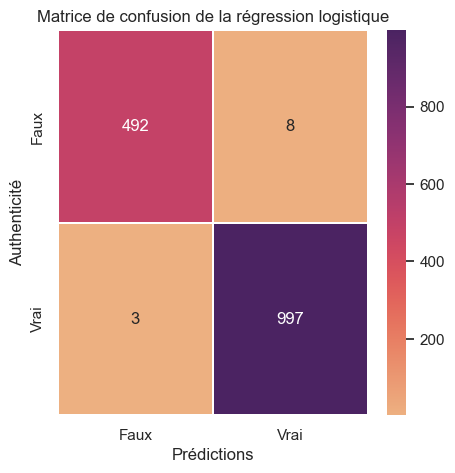

In [258]:
# Matrice de confusion:

n_reg_lin = 1500
conf_matrix_reg_log = model_reg_log.pred_table()
prct = (conf_matrix_reg_log*100)/n_reg_lin
print(prct)

# Graphique:
plt.figure(figsize=(5,5))
sns.heatmap(conf_matrix_reg_log,
            annot = True,
            fmt = ".3g", 
            cmap = sns.color_palette("flare", as_cmap=True),
            linecolor = "white",
            linewidths = 0.3,
            xticklabels = ["Faux","Vrai"],
            yticklabels=["Faux","Vrai"]
            )
plt.xlabel("Prédictions")
plt.ylabel("Authenticité")
plt.title("Matrice de confusion de la régression logistique")

## Evaluation de la performance du modèle :

### À partir de ces quatre éléments, plusieurs mesures peuvent être calculées pour évaluer la performance du modèle, telles que la précision, le rappel (ou sensibilité), la spécificité et le score F1.

In [259]:
print("Précision:",accuracy_score(df["is_genuine"], df["y_pred"]))
print("Spécificité:",precision_score(df["is_genuine"], df["y_pred"]))
print("Sensibilité:",recall_score(df["is_genuine"], df["y_pred"]))
print("Score F1:",recall_score(df["is_genuine"], df["y_pred"]))

Précision: 0.9926666666666667
Spécificité: 0.9920398009950249
Sensibilité: 0.997
Score F1: 0.997


<ol>
  <li>Précision = TP / (TP + FP)</li>
  <li>Sécificité = TN / (TN + FP)</li>
  <li>Sensibilité = TP / (TP + FN)</li>
  <li>Score F1 = 2 x (Précision x Sensibilité) / (Précision + Sensibilité)</li>
</ol>

<ol>
  <li>Avec True positives (TP) : le modèle a correctement prédit les échantillons positifs.</li>
  <li>False positives (FP) : le modèle a prédit à tort que les échantillons étaient positifs alors qu'ils étaient négatifs.</li>
  <li>False negatives (FN) : le modèle a prédit à tort que les échantillons étaient négatifs alors qu'ils étaient positifs.</li>
  <li> True negatives (TN) : le modèle a correctement prédit les échantillons négatifs</li>
</ol>

# <font color='red'>SCORE REGRESSION LOGISTIQUE : 0.997</font>  

## Application du modèle aux données test:


In [260]:
test

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


In [261]:
#Prédiction des données dans test
X_test = test[["height_right","margin_low","margin_up","length"]]
X_test = sm.add_constant(X_test)
test["Probabilité vrai billet"] = model_reg_log.predict(X_test)
test["Probabilité vrai billet"] = test["Probabilité vrai billet"]*100
test["Probabilité vrai billet"] = round(test["Probabilité vrai billet"],2)
test["Probabilité vrai billet"] = test["Probabilité vrai billet"].astype(str)+'%'
test["Prédiction"] = (model_reg_log.predict(X_test) >= 0.5).astype(int)
print(test[["id","Probabilité vrai billet","Prédiction"]])


    id Probabilité vrai billet  Prédiction
0  A_1                    0.0%           0
1  A_2                    0.0%           0
2  A_3                    0.0%           0
3  A_4                  99.62%           1
4  A_5                  100.0%           1


In [262]:
# Affichage des resultats:
print("\n\nIdentification des billets:")
for i, k in zip(test["Prédiction"],test["id"]):
    if i == 1:
        print("Le billet","{}".format(k),"est vrai")
    else:
        print("Le billet","{}".format(k),"est faux")



Identification des billets:
Le billet A_1 est faux
Le billet A_2 est faux
Le billet A_3 est faux
Le billet A_4 est vrai
Le billet A_5 est vrai


## K-Means:


In [263]:
df

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,proba,y_pred
72,True,171.94,103.89,103.45,4.064954,3.25,112.79,9.976943e-01,1
99,True,171.93,104.07,104.18,4.111990,3.14,113.08,9.981267e-01,1
151,True,172.07,103.80,104.38,4.134003,3.02,112.93,9.969801e-01,1
197,True,171.45,103.66,103.80,3.993571,3.62,113.27,9.886187e-01,1
241,True,171.83,104.14,104.06,4.140399,3.02,112.36,9.648486e-01,1
...,...,...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,4.420000,3.09,111.28,2.034358e-03,0
1496,False,172.19,104.63,104.44,5.270000,3.37,110.97,3.141317e-08,0
1497,False,171.80,104.01,104.12,5.510000,3.36,111.95,9.275712e-06,0
1498,False,172.06,104.28,104.06,5.170000,3.46,112.25,2.166620e-04,0


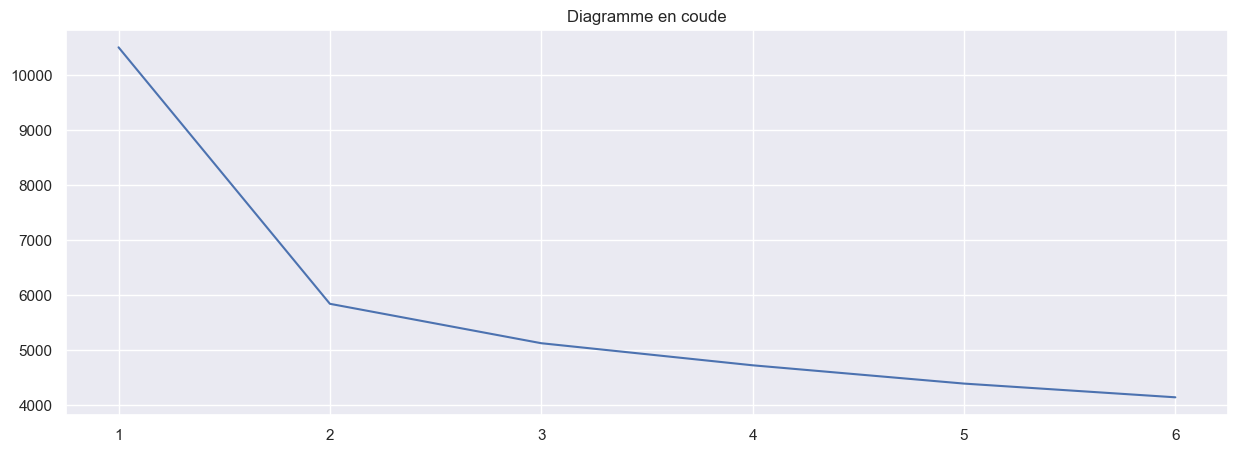

In [264]:
# Création de la courbe en coude
Y = X_scaled
silhouette = []
for k in range(1, 7):
    kmeans = KMeans(n_clusters=k) # création d'un objet de clustering
    kmeans.fit(Y) # clustering sur les données normalisées
    silhouette.append(kmeans.inertia_) # calcul du coefficient de silhouette

fig = plt.figure(figsize=(15, 5))
plt.plot(range(1, 7), silhouette)
plt.grid(True)
plt.title('Diagramme en coude')
plt.show()


In [265]:
# Nombre de clusters:
n_clust = 2

# Clustering par K-means:
km = KMeans(n_clusters=n_clust,random_state=1994)
x_km = km.fit_transform(df[["diagonal","height_left","height_right","margin_low","margin_up","length"]])


In [266]:
# Ajout d'une colonne contenant le cluster attribue:
clusters_km = km.labels_

centroids_km = km.cluster_centers_

# Clustering par projection des individus sur le premier plan factoriel:
pca_km = decomposition.PCA(n_components=3).fit(df[["diagonal","height_left","height_right","margin_low","margin_up","length"]])
acp_km = PCA(n_components=3).fit_transform(df[["diagonal","height_left","height_right","margin_low","margin_up","length"]])

centroids_km_projected = pca_km.transform(centroids_km)

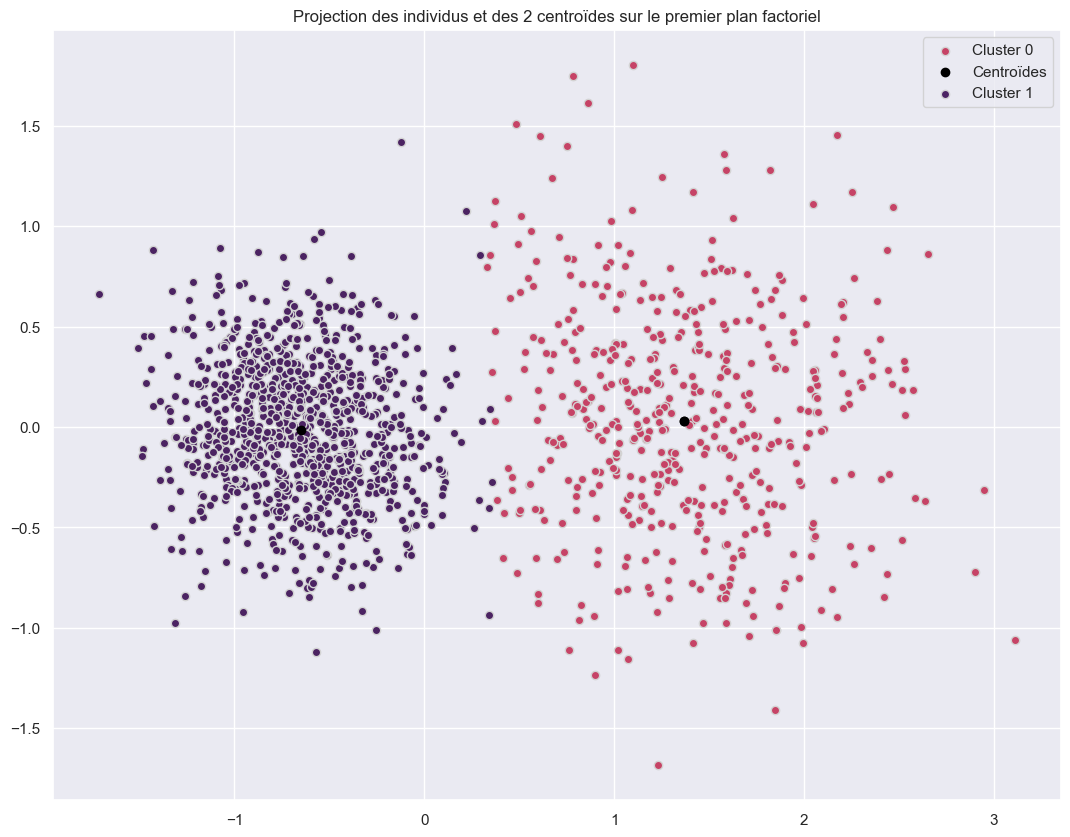

In [267]:
for couleur,k in zip(["#C64366","#4B2362"],[0,1]):
    plt.scatter(acp_km[km.labels_==k,0],acp_km[km.labels_==k,1],c=couleur,edgecolors="#D3D3D3",label="Cluster {}".format(k))
    plt.legend()
    plt.scatter(centroids_km_projected[:,0],centroids_km_projected[:,1],color="black",label="Centroïdes")
plt.title("Projection des individus et des {} centroïdes sur le premier plan factoriel".format(len(centroids_km)))
plt.show()

Text(0.5, 1.0, 'Matrice de confusion K-means\n')

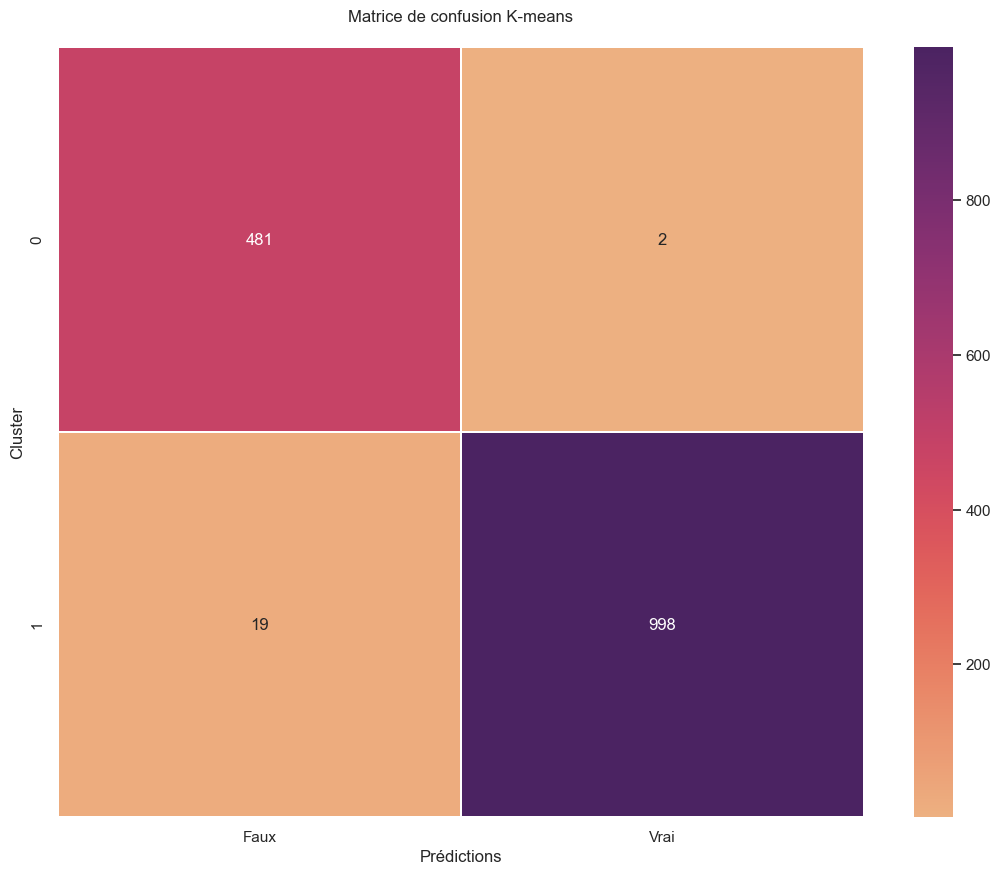

In [268]:
#Verfication de la classification
# Graphique:
km_matrix = pd.crosstab(clusters_km,df["is_genuine"])
sns.heatmap(km_matrix,
            annot = True,
            fmt = ".3g", 
            cmap = sns.color_palette("flare", as_cmap=True),
            linecolor = "white",
            linewidths = 0.3,
            xticklabels = ["Faux","Vrai"],
            yticklabels=["0","1"]
            )
plt.xlabel("Prédictions")
plt.ylabel("Cluster")
plt.title("Matrice de confusion K-means\n")

In [269]:
df

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,proba,y_pred
72,True,171.94,103.89,103.45,4.064954,3.25,112.79,9.976943e-01,1
99,True,171.93,104.07,104.18,4.111990,3.14,113.08,9.981267e-01,1
151,True,172.07,103.80,104.38,4.134003,3.02,112.93,9.969801e-01,1
197,True,171.45,103.66,103.80,3.993571,3.62,113.27,9.886187e-01,1
241,True,171.83,104.14,104.06,4.140399,3.02,112.36,9.648486e-01,1
...,...,...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,4.420000,3.09,111.28,2.034358e-03,0
1496,False,172.19,104.63,104.44,5.270000,3.37,110.97,3.141317e-08,0
1497,False,171.80,104.01,104.12,5.510000,3.36,111.95,9.275712e-06,0
1498,False,172.06,104.28,104.06,5.170000,3.46,112.25,2.166620e-04,0


In [270]:
df = df.drop(["proba", "y_pred"], axis=1)

## Algorithme K plus proches voisins (KNN)


### Validation croisée dans laquelle on séparera les données (dans notre cas on ne prendra que 33% des données pour le test)

In [271]:
#on stock les données explicatives dans la variable data
data = df.iloc[:,1:7]
#on stock la variable cible 'charges_classes' dans la variable target
target = df['is_genuine']

#on separe les données en un ensemble d'apprentissage et un ensemble de test(33%)
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.33) 

#on centre et reduit les variables explicatives des deux echantillons
X_train_scaled = preprocessing.scale(X_train)
y_train_scaled = preprocessing.scale(y_train)

In [272]:
score = []


for k in range(2, 50):
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    score.append(knn.score(X_test, y_test)) 

#on affiche les scores
print(score)

[0.9858585858585859, 0.9878787878787879, 0.9858585858585859, 0.9858585858585859, 0.9838383838383838, 0.9838383838383838, 0.9838383838383838, 0.9838383838383838, 0.9858585858585859, 0.9858585858585859, 0.9858585858585859, 0.9858585858585859, 0.9858585858585859, 0.9858585858585859, 0.9858585858585859, 0.9858585858585859, 0.9858585858585859, 0.9858585858585859, 0.9858585858585859, 0.9858585858585859, 0.9858585858585859, 0.9838383838383838, 0.9838383838383838, 0.9838383838383838, 0.9838383838383838, 0.9838383838383838, 0.9838383838383838, 0.9838383838383838, 0.9838383838383838, 0.9838383838383838, 0.9838383838383838, 0.9838383838383838, 0.9838383838383838, 0.9838383838383838, 0.9838383838383838, 0.9838383838383838, 0.9858585858585859, 0.9838383838383838, 0.9858585858585859, 0.9838383838383838, 0.9838383838383838, 0.9838383838383838, 0.9838383838383838, 0.9838383838383838, 0.9838383838383838, 0.9838383838383838, 0.9838383838383838, 0.9838383838383838]


In [273]:
#Création du classificateur et entraînement du modèle
knn_m = neighbors.KNeighborsClassifier(n_neighbors=2)
knn_m.fit(X_train, y_train)

#On applique le modèle aux données de l'ensemble de test et stocker les prédictions obtenues dans la variable y_pred.
y_pred = knn.predict(X_test)

#On affiche une matrice de confusion pour comparer les classes réelles et prédites.
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,False,True
Classe réelle,,
False,153,7
True,1,334


In [274]:
#Score du modèle 
score = knn_m.score(X_test, y_test)
score

0.9858585858585859

# <font color='red'>K plus proches voisins : 0.987</font>  


### Après comparaison : le score de regression logistique est de 0.997, celui de K plus proches voisin est de 0.987 et la méthode K-means comporte plus de faux/vrais négatifs que la matrice de confusion du score de regression logistique : c'est donc la regression logistique qui est la méthode la plus performante